In [57]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.loader import DataLoader
import pandas as pd
import random
import os
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GraphConv, NNConv
from tqdm import tqdm
import torch.optim as optim
import json
import pprint 

In [2]:
from helper_function_module import init_setup
seed = 87456
BATCH_SIZE = 70
device = init_setup(batch_size = BATCH_SIZE, 
           use_cuda = True, 
           random_seed = seed)

Using device: cpu
System CUDA Status:
- PyTorch version: 2.5.1+cu121
- CUDA Version: 12.1
- CUDA available: False

PyTorch Geometric Status:
- PyG version: 2.6.1
- torch_scatter: Installed
- torch_sparse: Installed
- torch_cluster: Installed
- torch_spline_conv: Installed


# Importing the Main tabular data

In [3]:
with open('json_data/signal_btag_label.json', 'r') as file:
    signal = json.load(file)

with open('json_data/background_btag_label.json', 'r') as file:
    background = json.load(file)

In [4]:
pp = pprint.PrettyPrinter(indent=2)

print(f"Signal Event: {len(signal)}")
print("Example:")
pp.pprint(signal[np.random.randint(0, len(signal))])
print(100*'~')

print(f"Background Event: {len(background)}")
print("Example:")
pp.pprint(background[np.random.randint(0, len(background))])

Signal Event: 119966
Example:
{ 'edge_index': [[0], [1]],
  'edges': [3.554905509698394],
  'event_label': 1,
  'eventno': 155069,
  'inv_mass': 119.30746642984421,
  'jet_btag_label': [0.0, 0.0],
  'jetmultiplicity': 2,
  'node_labels': [1, 1],
  'nodes': [ [1.64501, 1.48088, 37.6831, 101.256],
             [-0.804118, -1.09577, 28.2866, 37.9352]]}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Background Event: 126444
Example:
{ 'edge_index': [[0], [1]],
  'edges': [2.687206180843956],
  'event_label': 0,
  'eventno': 229615,
  'inv_mass': 36.52110596182952,
  'jet_btag_label': [0.0, 1.0],
  'jetmultiplicity': 1,
  'node_labels': [0, 1],
  'nodes': [ [0.0530316, -0.146326, 10.9979, 11.0134],
             [-0.373657, -2.79944, 30.6956, 32.8635]]}


# Converting Each Event into a PyG Graph Object

In [10]:
a = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
print(f'Before: \n{a}')
a = torch.flip(a, dims = [1,])
print(f'After: \n{a}')

max_tensor = torch.max(a, dim=0)

Before: 
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
After: 
tensor([[3, 2, 1],
        [6, 5, 4],
        [9, 8, 7]])


In [14]:
a/max_tensor.values

tensor([[0.3333, 0.2500, 0.1429],
        [0.6667, 0.6250, 0.5714],
        [1.0000, 1.0000, 1.0000]])

In [68]:
def convert_to_pyg_graph(graph):
    """
    Convert the graph dictionary into a PyTorch Geometric Data object
    and add graph-level features like jet_multiplicity, inv_mass, and the event label.

    Parameters:
    -----------
    graph : dict
        Dictionary containing 'eventno', 'nodes', 'edges', and 'edge_index', 'jet_multiplicity', 'inv_mass', 'node_labels',
        'jet_btag_labels', 'event_label' for a single event.

    Returns:
    --------
    data : Data
        PyTorch Geometric Data object containing the graph and additional features.
    """
    # Extract node features, edge features, and edge index from the graph dictionary
    event_num = torch.tensor(graph['eventno'], dtype=torch.long)
    
    node_features = torch.flip(torch.tensor(graph['nodes'], dtype=torch.float), dims = (1,))  # Shape: (3, num_features)

    #Normalizing Node Feature doesn't help...
    # normalized_node_features = node_features / torch.max(node_features, dim=0).values
    
    edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)  # Shape: (2, num_edges)
    edge_features = torch.tensor(graph['edges'], dtype=torch.float).view(-1,1)  # Shape: (num_edges, 1)
    node_labels = torch.tensor(graph['node_labels'], dtype=torch.float).view(-1,1)
    jet_btag_labels = torch.tensor(graph['jet_btag_label'], dtype=torch.float).view(-1,1)
    
    # Convert graph-level features (jet_multiplicity, inv_mass) and label to tensor
    graph_level_features = torch.tensor([graph['jetmultiplicity'],
                                         graph['inv_mass'],
                                         np.array(graph['edges']).std(),
                                        graph['node_labels'].count(0),
                                        graph['jet_btag_label'].count(1)], dtype=torch.float).view(1, -1)
    label_tensor = torch.tensor(graph['event_label'], dtype=torch.long)  # Event label (0 or 1)

    # Create the PyTorch Geometric Data object
    data = Data(
        x=node_features,    # Normalised Node features (3, num_features)
        edge_index=edge_index,         # Edge index (2, num_edges)
        edge_attr=edge_features,       # Edge features (num_edges, 1)
        y=label_tensor                 # Event label (0 or 1)
    )

    # Add custom graph-level features
    data.eventno = event_num
    data.jet_multiplicity = graph_level_features[0, 0]
    data.inv_mass = graph_level_features[0, 1]
    data.proximity_spread = graph_level_features[0, 2]
    data.count_isophoton = graph_level_features[0, 3]
    data.count_btag_jets = graph_level_features[0, 4]
    data.node_label = node_labels 
    data.jet_btag_label = jet_btag_labels

    return data

def convert_all_to_pyg_graphs(graphs):
    """
    Converts a list of event graphs to PyTorch Geometric-compatible Data objects.
    Also adds the graph-level features 'jet_multiplicity', 'inv_mass' and event labels.

    Parameters:
    -----------
    graphs : list of dicts
        List containing dictionaries with node, edge information for each event.
    dataframe : pd.DataFrame
        DataFrame containing the event-level features like 'jetmultiplicity', 'invmass_4j1p', and 'label'.

    Returns:
    --------
    pyg_graphs : list of Data
        List of PyTorch Geometric Data objects with added graph-level features and labels.
    """
    pyg_graphs = []
    print('Initializing the process...')
    with tqdm(total = len(graphs), desc = 'Progress', leave = True) as pbar:    
        for i, graph in enumerate(graphs):
            data = convert_to_pyg_graph(graph)
            pyg_graphs.append(data)
            pbar.update(1)
    print('Process completely successfully :)')
    return pyg_graphs

In [69]:
signal_pyg_graphs = convert_all_to_pyg_graphs(signal)
background_pyg_graphs = convert_all_to_pyg_graphs(background)

Initializing the process...


Progress:   0%|          | 0/119966 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Progress: 100%|██████████| 119966/119966 [00:17<00:00, 6953.91it/s]


Process completely successfully :)
Initializing the process...


Progress: 100%|██████████| 126444/126444 [00:17<00:00, 7166.36it/s]


Process completely successfully :)


In [70]:
dataset = []
for data in signal_pyg_graphs + background_pyg_graphs:
    num_nodes = data.x.size()[0]
    # Taking only those graph which have one isolated photon and  two btagged jets
    if (num_nodes == 3) & (data.count_isophoton.item() == 1) & (data.count_btag_jets.item() == 2):
        dataset.append(data)

In [92]:
# Randomly shuffling the data
random.seed(seed)
dataset = random.sample(dataset, len(dataset))
print(f'Dataset contains {len(dataset)} samples')

Dataset contains 2075 samples


In [99]:
print("Example Graph Data Object:")
ex = dataset[2000]
print(ex)

Example Graph Data Object:
Data(x=[3, 4], edge_index=[2, 3], edge_attr=[3, 1], y=0, eventno=466589, jet_multiplicity=2.0, inv_mass=163.26858520507812, proximity_spread=0.5391254425048828, count_isophoton=1.0, count_btag_jets=2.0, node_label=[3, 1], jet_btag_label=[3, 1])


In [100]:
ex.x

tensor([[ 8.4196e+01,  6.2425e+01, -2.8293e+00,  8.1264e-01],
        [ 1.0982e+02,  4.9151e+01,  2.3309e-02,  1.4427e+00],
        [ 1.2862e+02,  3.8916e+01,  1.5737e+00,  1.8649e+00]])

In [101]:
ex.eventno

tensor(466589)

In [102]:
ex.y.item()

0

In [103]:
for data in (background if ex.y.item() == 0 else signal):
    if data['eventno'] == ex.eventno.item():
        pp.pprint(data)

{ 'edge_index': [[0, 0, 1], [1, 2, 2]],
  'edges': [2.9213222088586344, 2.1547005514967577, 1.6067909671409315],
  'event_label': 0,
  'eventno': 466589,
  'inv_mass': 163.26857774025683,
  'jet_btag_label': [0.0, 1.0, 1.0],
  'jetmultiplicity': 2,
  'node_labels': [0, 1, 1],
  'nodes': [ [0.812635, -2.82925, 62.4246, 84.196],
             [1.44274, 0.0233087, 49.151, 109.818],
             [1.8649, 1.57365, 38.9162, 128.622]]}


# Train-Test Splits

In [104]:
num_graphs = len(dataset)
train_ratio, test_ratio = 0.7, 0.3
train_size = int(train_ratio * num_graphs)
test_size = num_graphs - train_size

# Random split
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


In [105]:
len(train_loader)

21

# Graph Visualization

In [106]:
def visualize_graph(data, *, save_fig=False, save_fig_path=None) -> None:
    """
    Visualize a graph with node features, labels, and edge attributes.
    
    Parameters:
    -----------
    data : Data
        PyTorch Geometric Data object with:
        - x: Node features [η, φ, pT, E]
        - node_label: Node type labels
        - edge_attr: Edge distances (ΔR)
        - eventno: Event number
        - y: Signal (1) vs background (0)
    """
    G = to_networkx(data, to_undirected=True, edge_attrs=["edge_attr"])
    
    # Create labels and feature strings
    node_labels = {i: f'{label.item()}' for i, label in enumerate(data.node_label)}
    node_features = {
        i: (data.x[i][0].item(),   # E
            data.x[i][1].item(),   # pT
            data.x[i][2].item(),   # φ
            data.x[i][3].item())   # η
        for i in range(data.num_nodes)
    }

    plt.figure(figsize=(5, 3), dpi = 300)
    pos = nx.spring_layout(G, seed=42, k=0.15)

    # Draw base graph
    nx.draw(G, pos, with_labels=True, node_size=500,
            node_color='skyblue', font_size=10, 
            font_weight='bold', edge_color='gray', 
            labels=node_labels)

    # Add node feature annotations
    for node, (E, pT, phi, eta) in node_features.items():
        x, y = pos[node]
        feature_str = (f"E: {E:.2f}\n"
                       f"pT: {pT:.2f}\n"
                       f"φ: {phi:.1f}\n"
                       f"η: {eta:.1f}")
        plt.text(x+0.12, y-0.12, feature_str, 
                 ha='center', va='top', 
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'),
                 fontsize=8, fontfamily='monospace')

    # Add edge distances
    edge_labels = nx.get_edge_attributes(G, 'edge_attr')
    edge_labels = {key: round(edge_labels[key][0], 2) for key in edge_labels}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                font_size=8)

    # Custom title
    event_type = "Signal" if data.y.item() == 1 else "Background"
    plt.title(f"{event_type} Event No.{data.eventno.item()}", fontsize=12)

    if save_fig and save_fig_path:
        plt.savefig(save_fig_path, bbox_inches='tight', pad_inches=0.1)
        print(f"Figure saved to {save_fig_path}")

    plt.show()
    return None

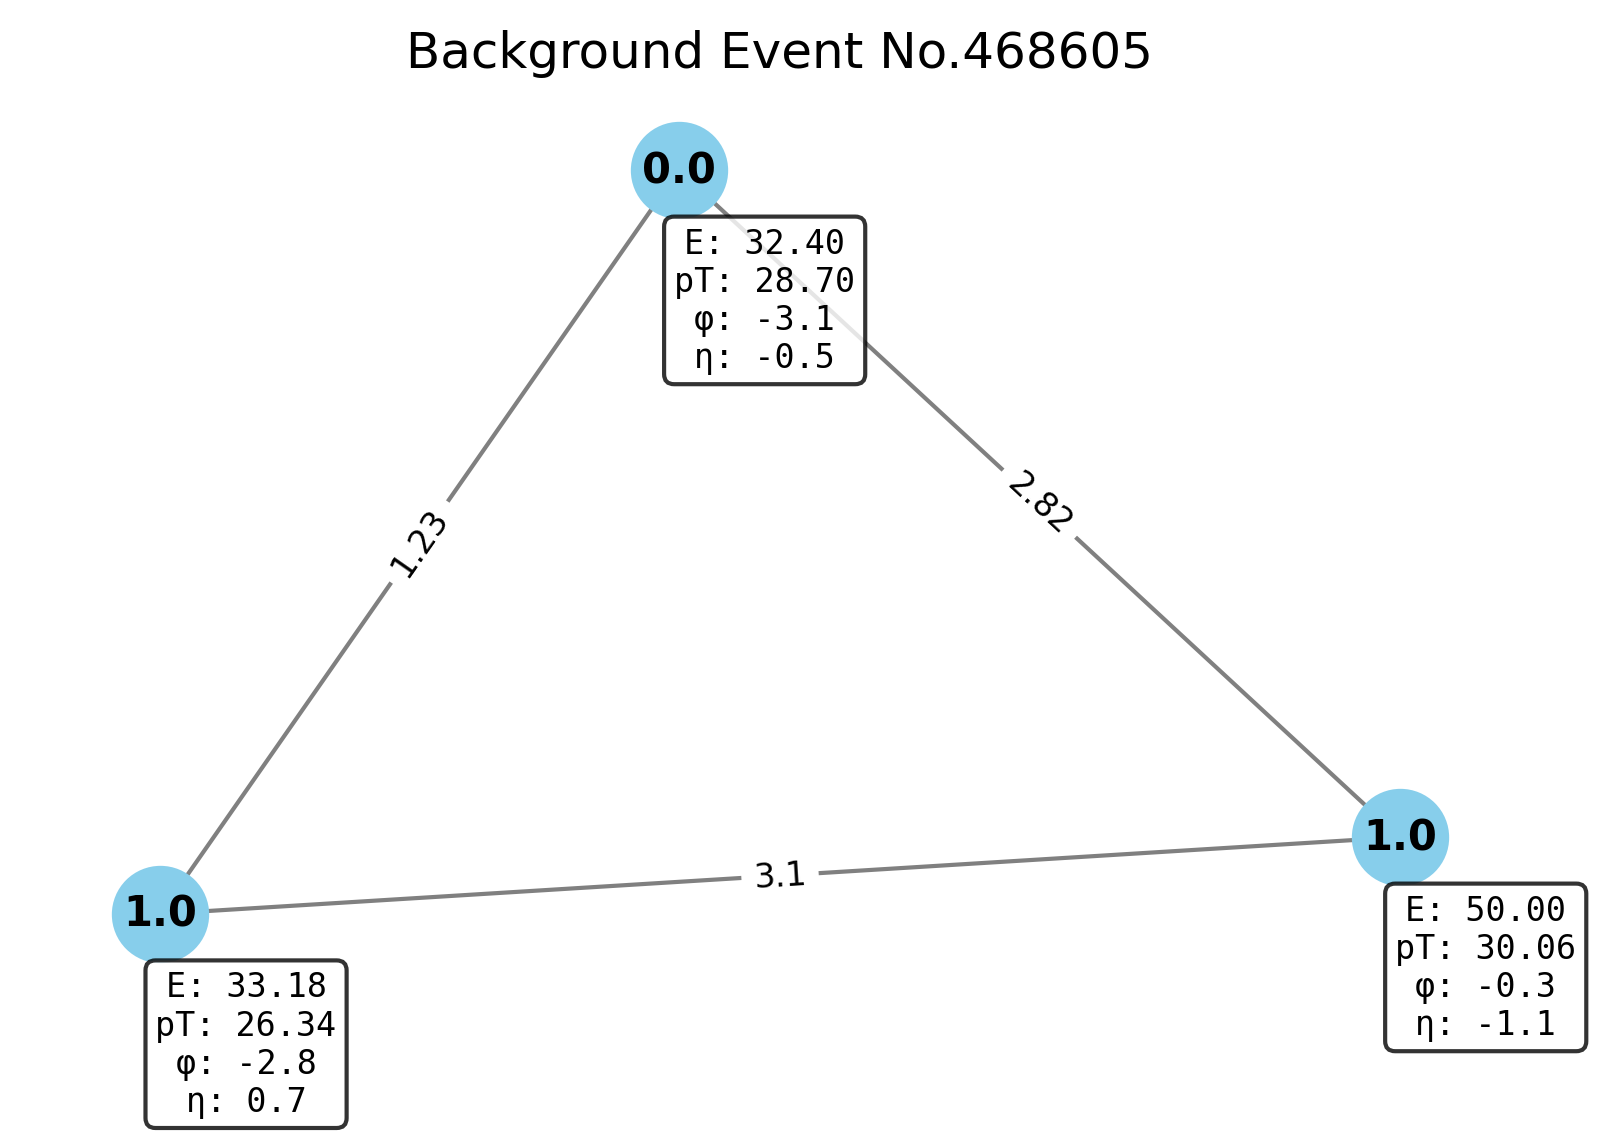

In [107]:
# from helper_function_module import visualize_graph
visualize_graph(dataset[54], save_fig = False, save_fig_path = 'eventGraph.png')

## Model 4 Best

In [108]:
class GCNClassifier(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim, num_graph_features,*, num_hidden_graph_features=0):
        """
        GCN architecture for graph classification.

        Parameters:
        -----------
        num_node_features : int
            Number of features for each node.
        hidden_dim : int
            Dimension of the hidden layer embeddings.
        num_graph_features : int
            Number of additional graph-level features.
        """
        super(GCNClassifier, self).__init__()

        if num_hidden_graph_features != 0:
            self.classify = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim + num_hidden_graph_features, 64),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(64, 1)
            )
            
            self.graph_features_nn = torch.nn.Sequential(
            torch.nn.Linear(num_graph_features, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(64, num_hidden_graph_features)
            )
            
        else:
            self.classify = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim + num_graph_features, 64),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(64, 1)
            )

        self.lin0 = torch.nn.Linear(num_node_features, hidden_dim)

        # self.conv1 = GraphConv(hidden_dim, hidden_dim, aggr = 'max')

        self.edge_nn = torch.nn.Sequential(
            torch.nn.Linear(num_edge_features, 64),
             torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(64, 128),
             torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
             torch.nn.Linear(128, hidden_dim * hidden_dim)
        )
        
        self.conv2 = NNConv(hidden_dim, hidden_dim, nn = self.edge_nn, aggr='max')
        self.global_mean_pool_hook = global_mean_pool
        
        

    def forward(self, data):
        """
        Forward pass of the GCN model.

        Parameters:
        -----------
        data : Data
            PyTorch Geometric Data object containing graph and its features.

        Returns:
        --------
        out : torch.Tensor
            Predicted probabilities for the graph labels.
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # GCN layers
        x = F.relu(self.lin0(x))
        # x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        
        x = self.global_mean_pool_hook(x, data.batch)  # Shape: (batch_size, hidden_dim)

        graph_features = torch.cat([data.inv_mass.view(-1, 1)], dim=1)
        x = torch.cat([x, graph_features], dim=1)
        self.graph_embedding = x
        # Fully connected layers
        x = self.classify(x)

        return torch.sigmoid(x) 


## Network Training

In [109]:
from helper_function_module import train, test
model = GCNClassifier(num_node_features=4,
                      num_edge_features = 1,
                      hidden_dim=10,
                      num_graph_features=1,
                      num_hidden_graph_features = 0).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4, amsgrad = False)
criterion = torch.nn.BCELoss().to(device)

EPOCHS = 250
training_loss = []
test_accuracy = []
torch.cuda.empty_cache()

with tqdm(total=EPOCHS, desc="Training Progress", leave=True) as pbar:
    for epoch in range(EPOCHS):
        loss = train(model, train_loader, device, optimizer, criterion)
        acc = test(model, test_loader, device, optimizer, criterion)
        training_loss.append(loss)
        test_accuracy.append(acc)

        pbar.set_postfix({'Loss': f'{loss:.4f}', 'Accuracy': f'{acc:.4f}'})
        pbar.update(1)

Training Progress: 100%|██████████| 250/250 [01:07<00:00,  3.68it/s, Loss=0.4476, Accuracy=0.7865]


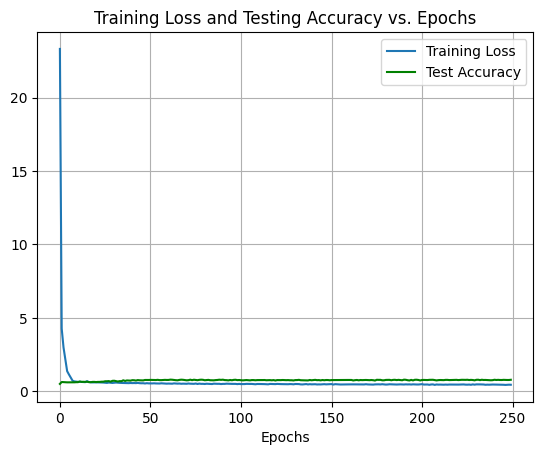

In [110]:
plt.plot([epoch for epoch in range(EPOCHS)], training_loss, label = 'Training Loss')
plt.plot([epoch for epoch in range(EPOCHS)], test_accuracy, color = 'g', label = 'Test Accuracy')
plt.legend()
plt.title('Training Loss and Testing Accuracy vs. Epochs')
plt.xlabel('Epochs')
# plt.ylim([0,2])
plt.grid(which = 'both')
# plt.savefig('GCNConvTrainingLoss_TestAccuracy.png', dpi=300)
plt.show()

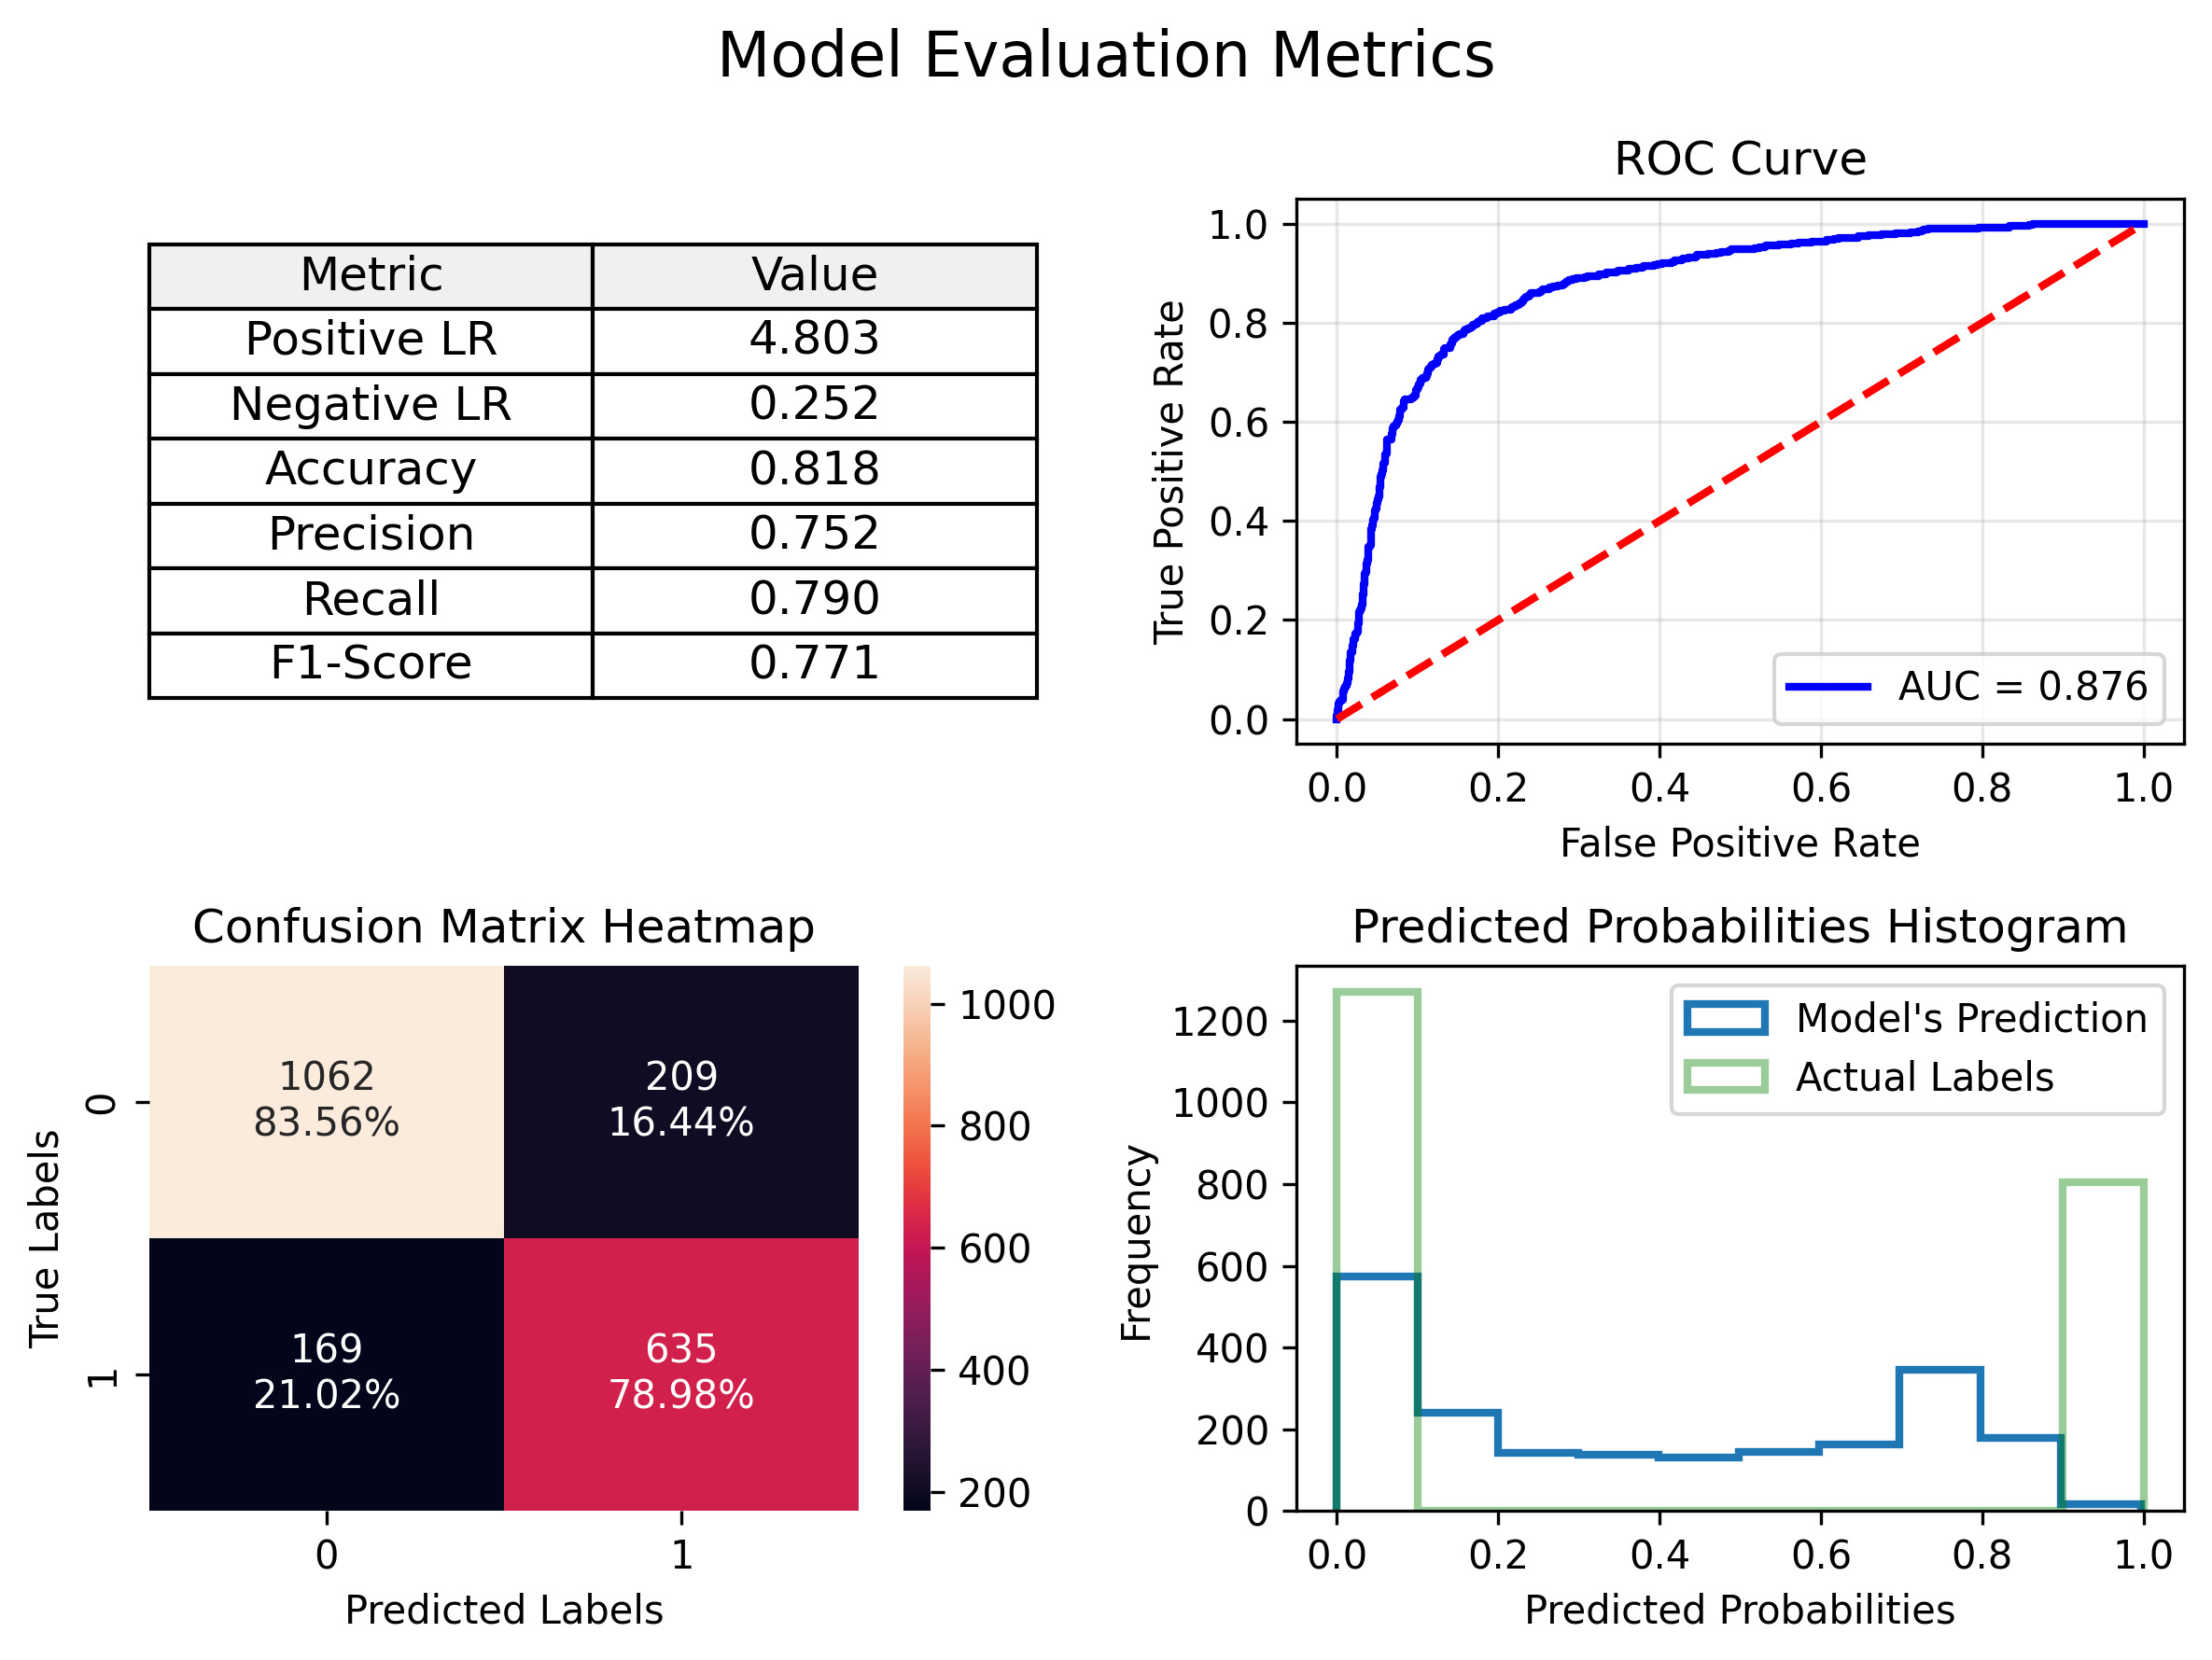

In [111]:
from helper_function_module import eval_model, get_labels_from_model
y_true, y_pred_prob, y_pred_labels = get_labels_from_model(model, dataset)
eval_model(y_true, y_pred_prob, y_pred_labels, save_fig = False, save_fig_path = 'GCNConvMetricPlot.png')

In [112]:
from collections import Counter
Counter(y_true)

Counter({0.0: 1271, 1.0: 804})

In [113]:
# np.save('NNConv_main_model', np.vstack((y_true, y_pred_prob)))
# torch.save(model, 'NNConv_main_model.pth')

# Testing the Model Performance on Test Data

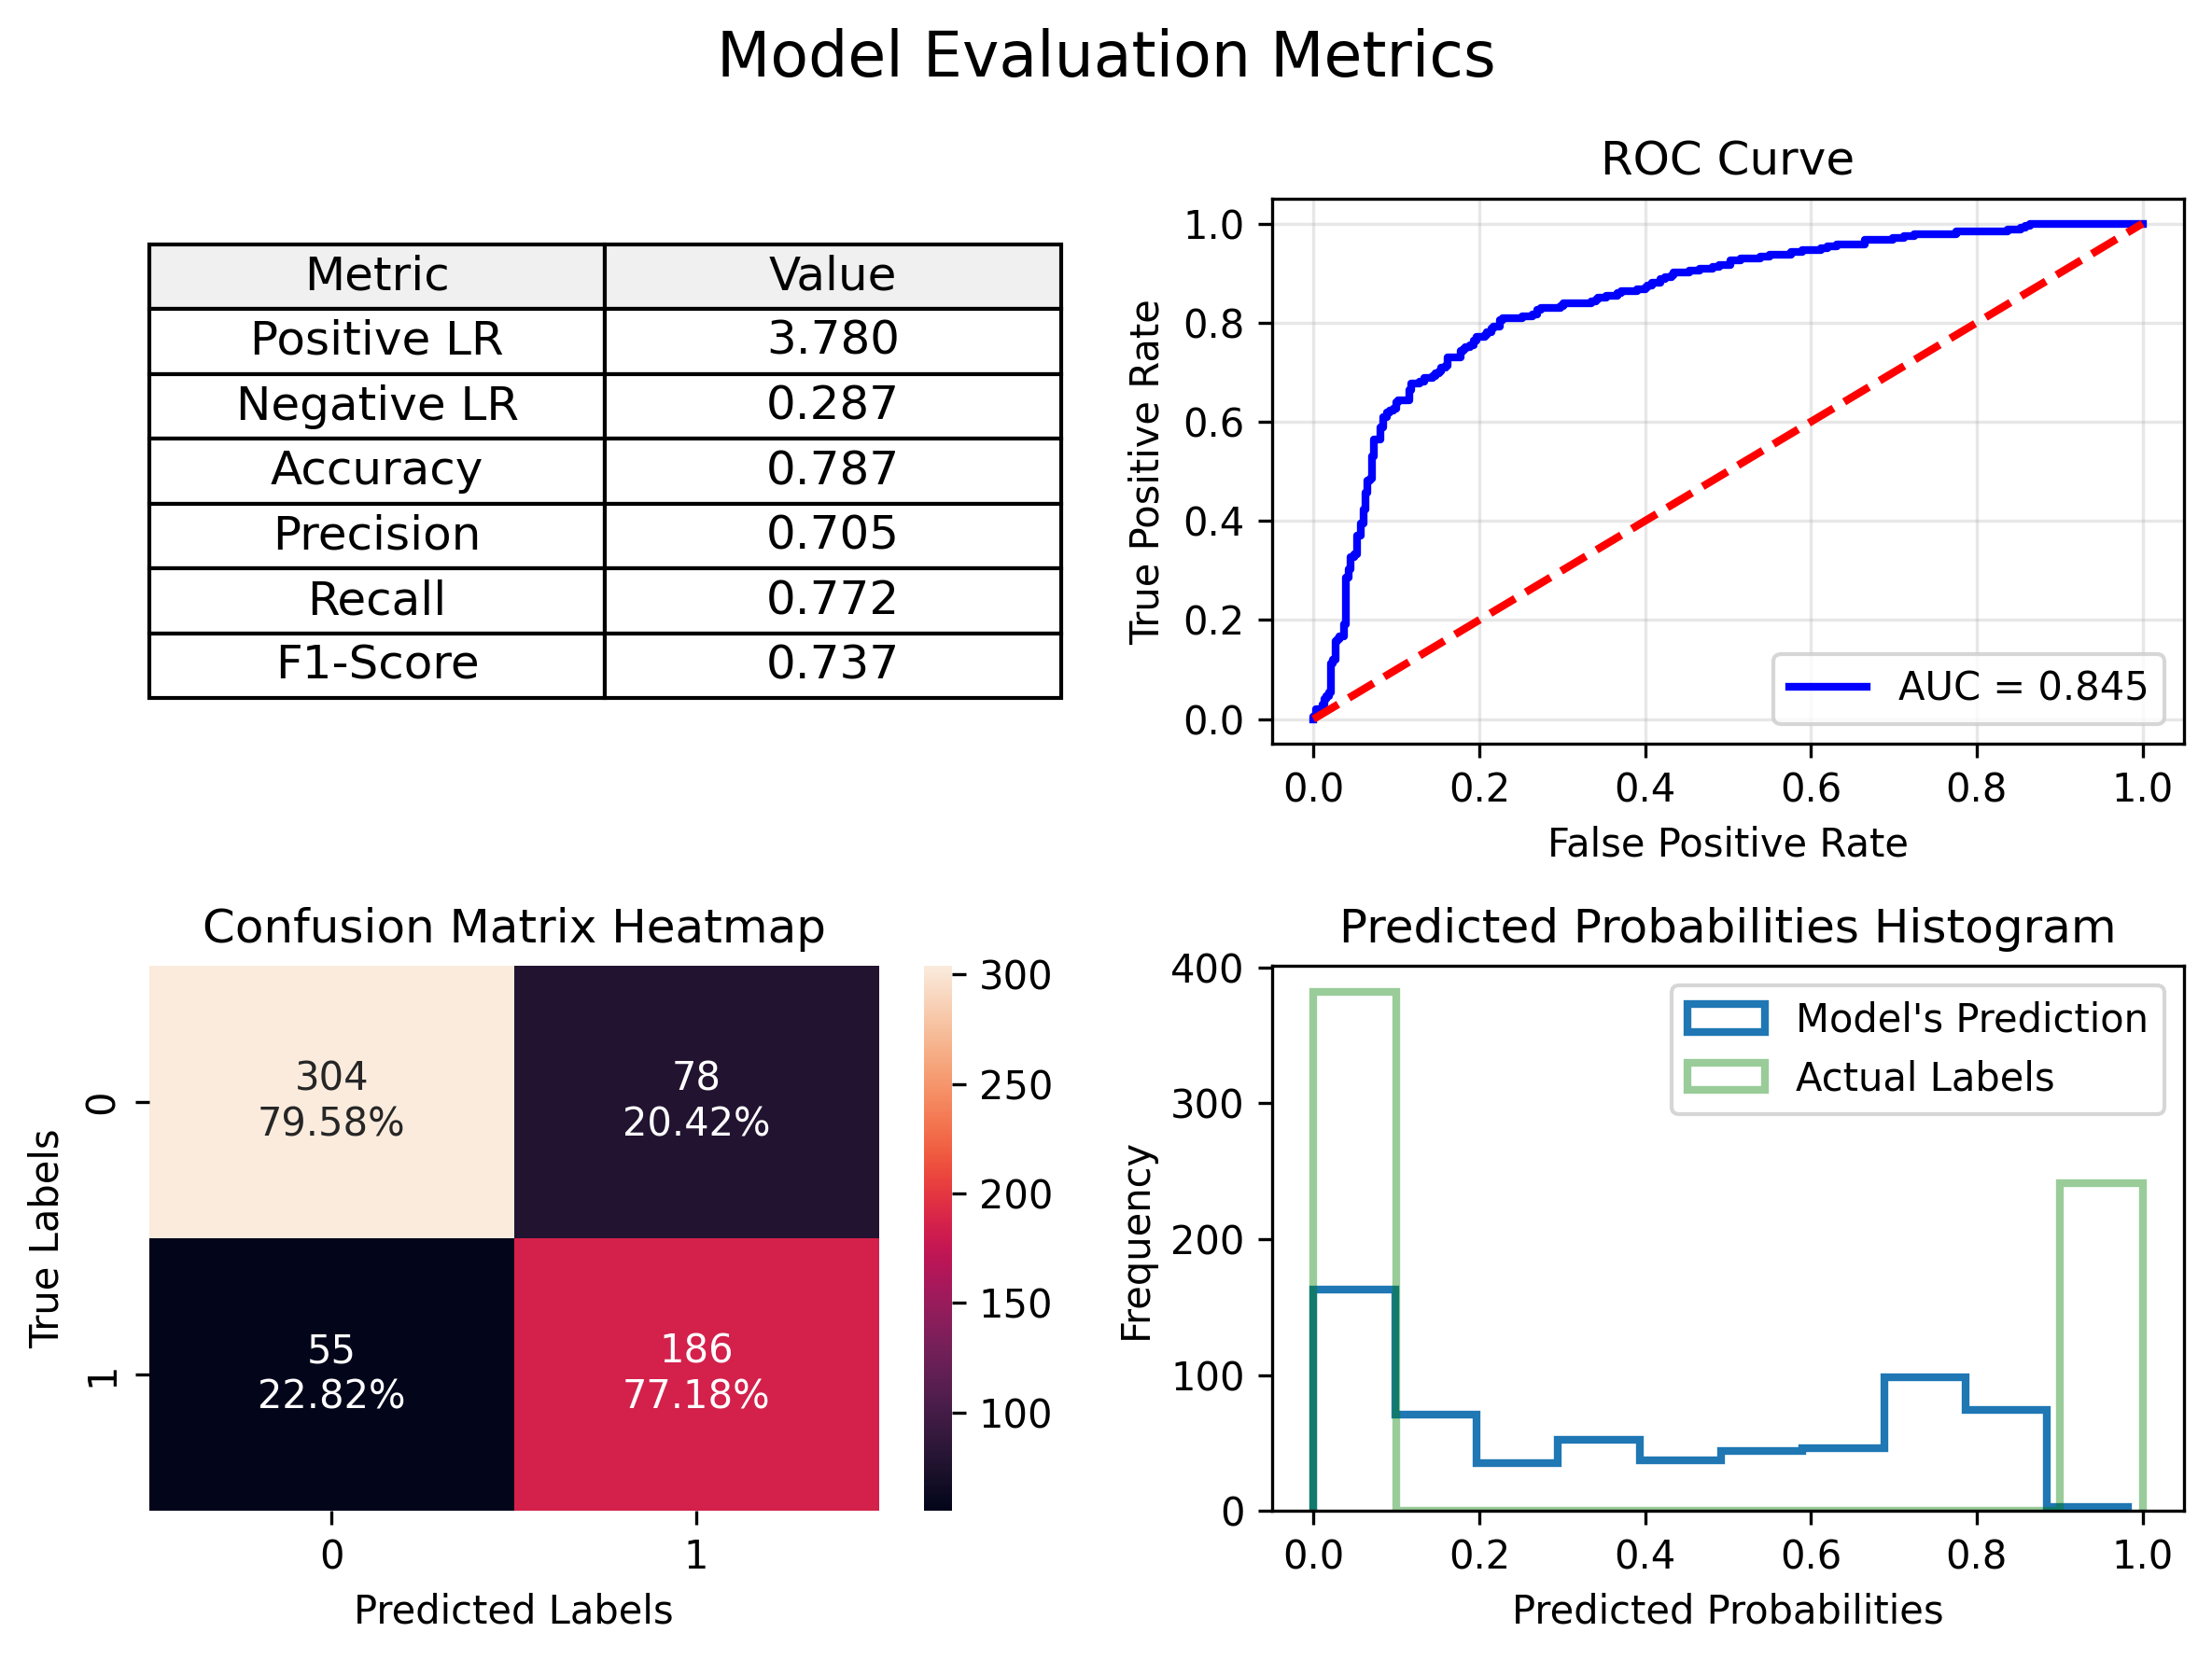

In [114]:
y_test_true, y_test_pred_prob, y_test_pred_labels = get_labels_from_model(model, test_dataset)
eval_model(y_test_true, y_test_pred_prob, y_test_pred_labels, save_fig = False, save_fig_path = 'GCNConvMetricPlot.png')

# Explaining the predictions

Now we look at two popular attribution methods. First, we calculate the gradient of the output with respect to the edge weights $w_{e_i}$. Edge weights are initially one for all edges.
For the saliency method, we use the absolute value of the gradient as the attribution value for each edge:

$$
Attribution_{e_i} = |\frac{\partial F(x)}{\partial w_{e_i}}|
$$

Where $x$ is the input and $F(x)$ is the output of the GNN model on input $x$.

For Integrated Gradients method, we interpolate between the current input and a baseline input where the weight of all edges is zero and accumulate the gradient values for each edge:

$$
Attribution_{e_i} = \int_{\alpha =0}^1 \frac{\partial F(x_{\alpha)}}{\partial w_{e_i}} d\alpha
$$

Where $x_{\alpha}$ is the same as the original input graph but the weight of all edges is set to $\alpha$. Integrated Gradients complete formulation is more complicated but since our initial edge weights are equal to one and the baseline is zero, it can be simplified to the formulation above. You can read more about this method [here](https://arxiv.org/abs/1703.01365). Of course, this can not be calculated directly and is approximated by a discrete sum.

We use the [captum](https://captum.ai/) library for calculating the attribution values. We define the `model_forward` function which calculates the `batch` argument assuming that we are only explaining a single graph at a time.



## Node Wise Saliency Map

In [115]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from torch_geometric.utils import to_networkx
from captum.attr import Saliency
import seaborn as sns

# Function to compute node saliency
def compute_node_saliency(model, data):
    model.eval()
    data.x.requires_grad = True  # Enable gradient tracking for node features

    output = model(data).squeeze()  # Forward pass
    model.zero_grad()
    output.backward(retain_graph=True)  # Compute gradients

    # Compute node importance as sum of absolute gradients over features
    node_saliency = data.x.grad.abs().sum(dim=1).detach()
    return node_saliency, output.item()  # Return model prediction probability too

# Function to compute edge importance
def compute_edge_importance(model, data):
    model.eval()
    data.edge_attr.requires_grad = True  # Enable gradient tracking for edge attributes

    output = model(data).squeeze()
    model.zero_grad()
    output.backward(retain_graph=True)

    # Compute edge importance as sum of absolute gradients over features
    edge_importance = data.edge_attr.grad.abs().sum(dim=1).detach()
    return edge_importance

# Function to compute feature-wise saliency
def compute_feature_importance(model, data):
    model.eval()
    data.x.requires_grad = True

    output = model(data).squeeze()
    model.zero_grad()
    output.backward(retain_graph=True)

    # Feature-wise importance per node
    feature_saliency = data.x.grad.abs().detach()
    return feature_saliency

# Function to visualize results in a 1x2 subplot
def visualize_graph_and_features(data, node_saliency, edge_importance, feature_saliency, prediction_prob):
    G = to_networkx(data, to_undirected=True)  # Convert to NetworkX graph
    node_size = (node_saliency.numpy() * 800) + 500  # Scale node sizes
    edge_width = (edge_importance.numpy() * 5) + 0.5  # Scale edge width

    node_labels = {0: "Isophoton", 1: "Jet 1", 2: "Jet 2"}  # node labels
    feature_labels = [r"$\eta$", r"$\phi$", r"$p_T$", r"$E$"][::-1]  # Feature names
    node_label_list = ["Isophoton", "Jet 1", "Jet 2"]

    # Create a 1x2 subplot
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Graph Visualization (Left)
    pos = nx.spring_layout(G)  # Layout for visualization
    nx.draw(G, pos, node_size=node_size, width=edge_width, with_labels=True, ax=axs[0])

    # Add node saliency scores as text beside nodes
    for i, (x, y) in pos.items():
        axs[0].text(x, y + 0.08, f"{node_saliency[i]:.2f}", fontsize=18, ha="center", color="red", fontweight = 'bold')

    # Add edge saliency scores as text beside edges
    for i, (start, end) in enumerate(data.edge_index.t().tolist()):
        x, y = (pos[start] + pos[end]) / 2
        axs[0].text(x+0.05, y-0.05, f"{edge_importance[i]:.2f}", fontsize=18, ha="center", color="blue", fontweight = 'bold')

    axs[0].set_title("Graph: Node & Edge Importance with Saliency Scores")

    # Feature-wise saliency heatmap
    im = sns.heatmap(feature_saliency.numpy(), 
                     annot = True,
                     fmt = '.5f', 
                     ax = axs[1])
    
    axs[1].set_xticks(np.arange(0.5, len(feature_labels)+0.5))
    axs[1].set_xticklabels(feature_labels, fontsize=14)

    axs[1].set_yticks(np.arange(0.5, len(node_label_list)+0.5))
    axs[1].set_yticklabels(node_label_list, fontsize=14)

    axs[1].set_xlabel("Feature", fontsize=16)
    axs[1].set_ylabel("Node", fontsize=16)
    axs[1].set_title("Feature-wise Saliency Heatmap")

    # Add prediction probability & true label in suptitle
    true_label = data.y.item()  # Extract true label
    fig.suptitle(f"Model Prediction: {prediction_prob:.4f} | True Label: {true_label}", fontsize=20, fontweight="bold")

    plt.tight_layout()
    plt.show()

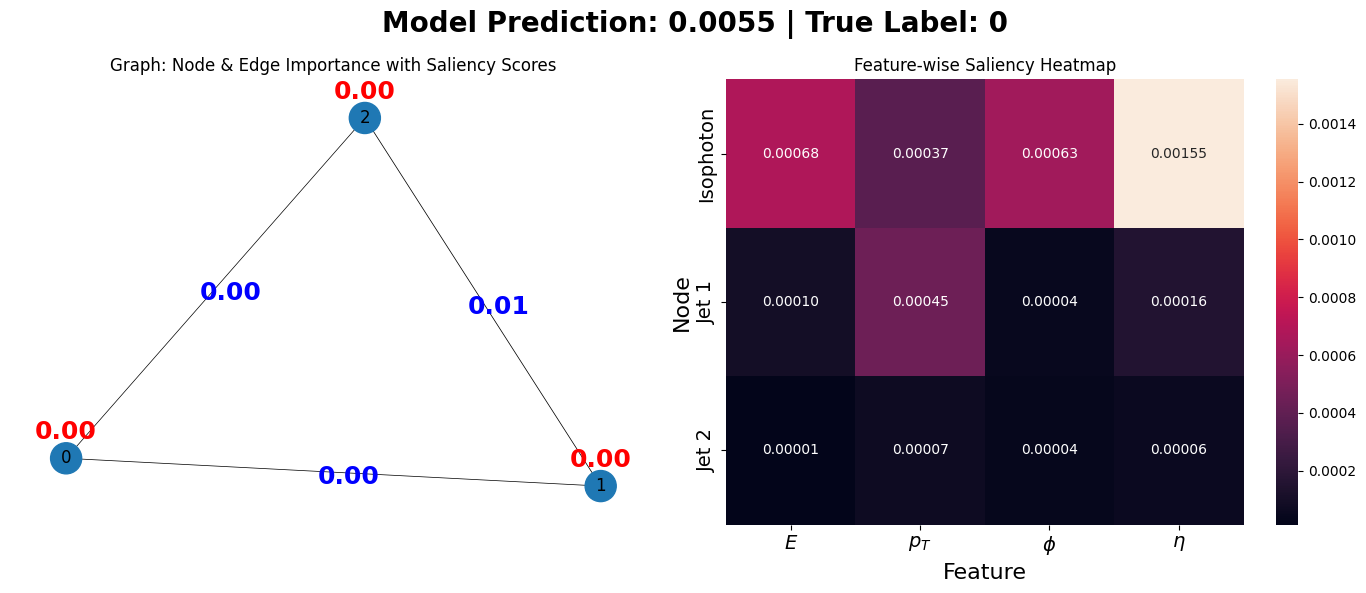

In [116]:
# False Positive
data = dataset[564]

node_saliency_scores, pred_prob = compute_node_saliency(model, data)
edge_importance_scores = compute_edge_importance(model, data)
feature_saliency_scores = compute_feature_importance(model, data)

visualize_graph_and_features(data, node_saliency_scores, edge_importance_scores, feature_saliency_scores, pred_prob)

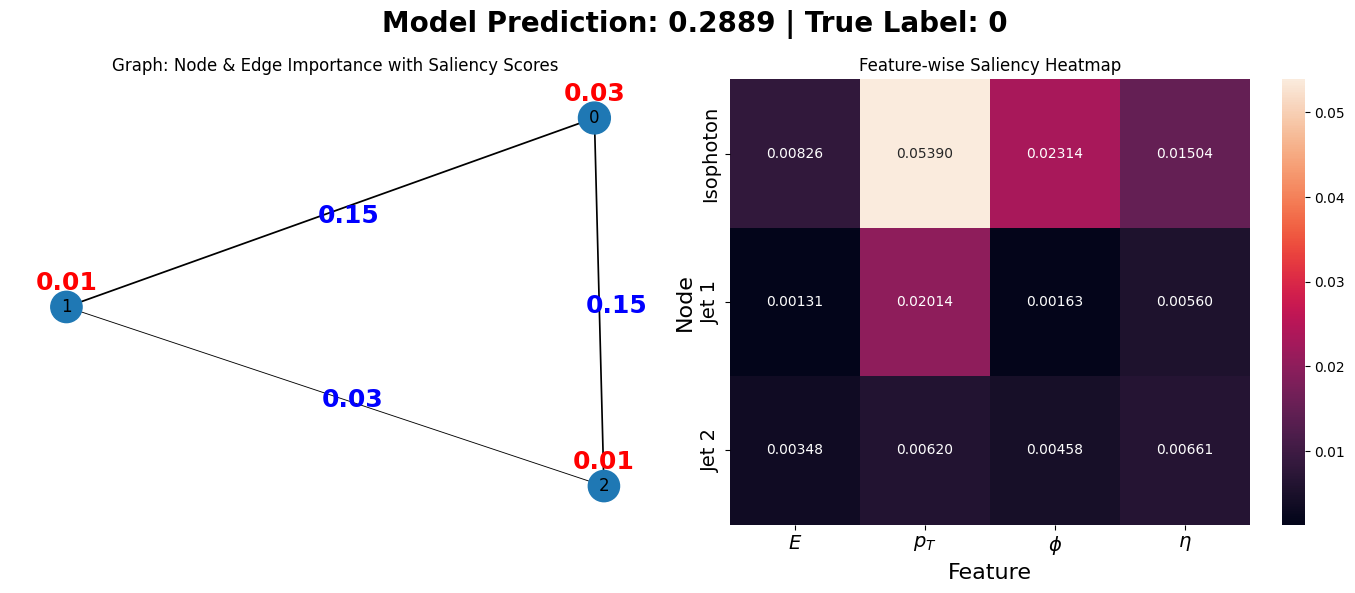

In [117]:
# False Negative
data = dataset[657]

node_saliency_scores, pred_prob = compute_node_saliency(model, data)
edge_importance_scores = compute_edge_importance(model, data)
feature_saliency_scores = compute_feature_importance(model, data)

visualize_graph_and_features(data, node_saliency_scores, edge_importance_scores, feature_saliency_scores, pred_prob)

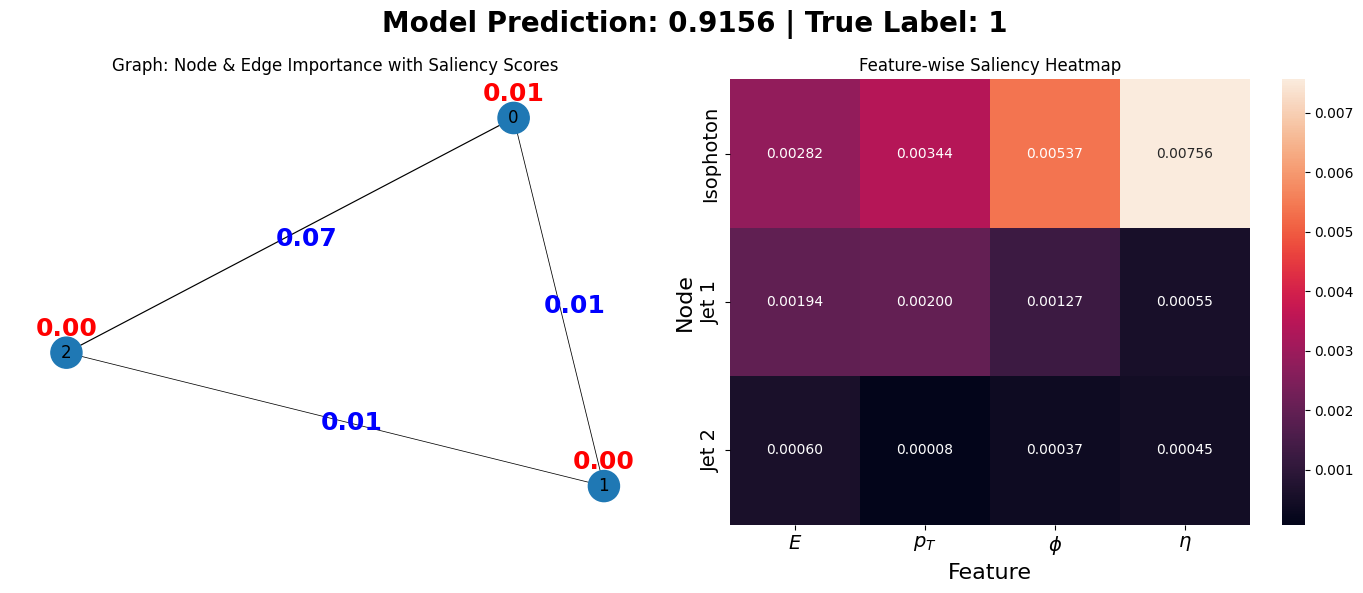

In [118]:
# True Positive
data = dataset[1239]

node_saliency_scores, pred_prob = compute_node_saliency(model, data)
edge_importance_scores = compute_edge_importance(model, data)
feature_saliency_scores = compute_feature_importance(model, data)

visualize_graph_and_features(data, node_saliency_scores, edge_importance_scores, feature_saliency_scores, pred_prob)

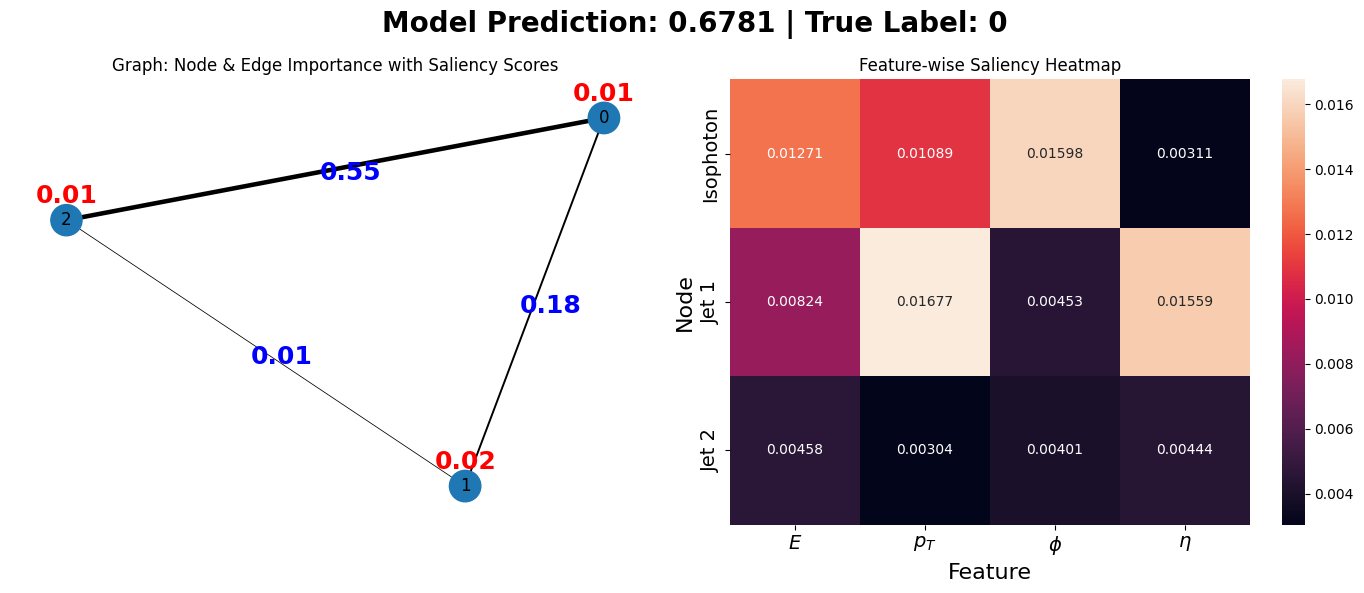

In [119]:
# True Negative
data = dataset[2000]

node_saliency_scores, pred_prob = compute_node_saliency(model, data)
edge_importance_scores = compute_edge_importance(model, data)
feature_saliency_scores = compute_feature_importance(model, data)

visualize_graph_and_features(data, node_saliency_scores, edge_importance_scores, feature_saliency_scores, pred_prob)

# Extracting Graph Embedding from the Model

In [24]:
from helper_function_module import get_graph_embeddings
embedding_df = get_graph_embeddings(model, dataset)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Classifying the Graph Embeddings Using a Random Forest Model from these graph embeddings

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

In [26]:
X, y = embedding_df.iloc[:,:-2].values, embedding_df.iloc[:,-2].values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [27]:
param_grid_forest = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}
grid_search_forest = GridSearchCV(RandomForestClassifier(random_state=seed),
                          param_grid=param_grid_forest,
                          cv=5,
                          n_jobs=-1)
grid_search_forest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

Best Model Test Accuracy: 0.85
Best Hyperparameters: {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 100}
ROC AUC: 0.90


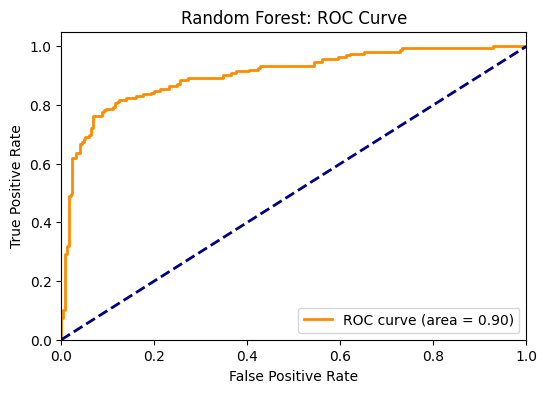

In [28]:
best_model = grid_search_forest.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Model Test Accuracy: {accuracy:.2f}')
print(f'Best Hyperparameters: {grid_search_forest.best_params_}')

# Calculate ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.2f}')

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest: ROC Curve')
plt.legend(loc="lower right")
plt.show()

## ANN Based Classifier

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

2025-02-01 14:28:30.640677: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-01 14:28:31.011385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738420111.183598    4369 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738420111.233114    4369 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-01 14:28:31.643485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [30]:
input_size = X.shape[1]
model_ANN = Sequential([
    Input((input_size,)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_ANN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Train the model
history = model_ANN.fit(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/40


2025-02-01 14:28:34.008142: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - AUC: 0.5104 - Precision: 0.3875 - Recall: 0.3583 - accuracy: 0.5317 - loss: 3.9772 - val_AUC: 0.3488 - val_Precision: 0.4036 - val_Recall: 1.0000 - val_accuracy: 0.4036 - val_loss: 0.8151
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.5543 - Precision: 0.4002 - Recall: 0.3637 - accuracy: 0.5450 - loss: 1.1592 - val_AUC: 0.5000 - val_Precision: 0.4036 - val_Recall: 1.0000 - val_accuracy: 0.4036 - val_loss: 0.6941
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.5055 - Precision: 0.3902 - Recall: 0.6117 - accuracy: 0.4852 - loss: 0.7750 - val_AUC: 0.5000 - val_Precision: 0.4036 - val_Recall: 1.0000 - val_accuracy: 0.4036 - val_loss: 0.6933
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.5214 - Precision: 0.3789 - Recall: 0.2579 - accuracy: 0.5557 - loss: 0.7173 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5964 - val_loss: 0.6914
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7

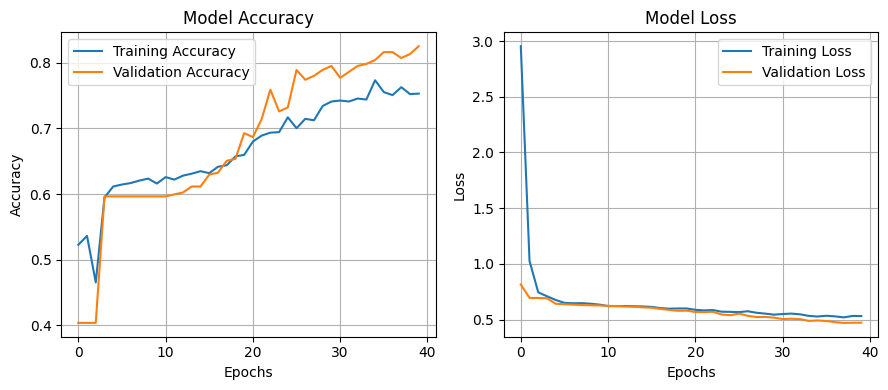

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8678 - Precision: 0.7479 - Recall: 0.8003 - accuracy: 0.8195 - loss: 0.4719 
Test Loss: 0.4781, Test Accuracy: 0.8072, Precision: 0.7457, Recall: 0.7818, AUC: 0.8614
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Example probabilities: [[0.09010976]
 [0.63944864]
 [0.19588193]
 [0.22794402]
 [0.23413056]]
Precision: 0.7457, Recall: 0.7818, F1 Score: 0.7633, ROC AUC: 0.8609


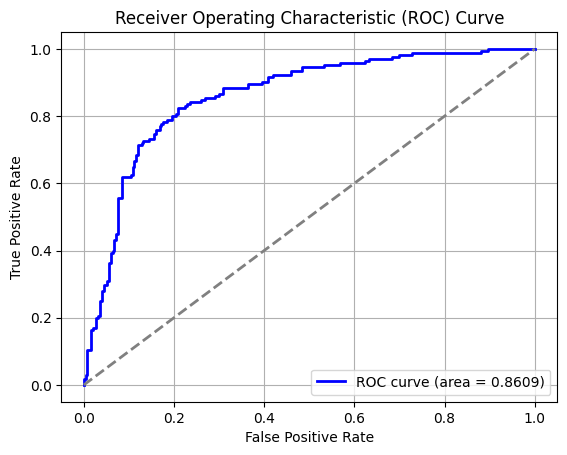

In [31]:
# Plotting training history
plt.figure(figsize=(9, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
evaluation_results = model_ANN.evaluate(X_test, y_test)
loss, accuracy, precision, recall, auc = evaluation_results
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")

# Predict probabilities for the test set
probability_scores = model_ANN.predict(X_test)
print("Example probabilities:", probability_scores[:5])

# Additional evaluation metrics
predictions = (probability_scores > 0.5).astype(int)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, probability_scores)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probability_scores)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()